In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Add, BatchNormalization, ZeroPadding2D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, Dense, SeparableConv2D
import matplotlib.pyplot as plt
import pydot as pyd
from IPython.display import SVG
import PIL
from sklearn.model_selection import train_test_split
import os
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tensorflow.keras.models import Model


In [2]:
tf.config.list_physical_devices("GPU") # True/False


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
images = []
labels = ["cat", "dog"]
y = []
data_path = os.getcwd() + "\\data"

for label in labels: 
    image_path = os.path.join(data_path, label) 
    # get images 
    for file in os.listdir(image_path)[:10000]: 
        try: 
            file_path = os.path.join(image_path, file)
            img = PIL.Image.open(file_path)
            # convert to numpy array 
            resized_img = img.resize((96, 96))
            image_matrix = np.asarray(resized_img)
            if image_matrix.shape == (96, 96, 3):                 
                images.append(image_matrix)
                y.append(label)
        except OSError as e:
            print(f"Something wrong with this image : {file_path}")


Something wrong with this image : C:\Users\valentin\Desktop\learn_neural_nets\convolutions\resnet50\data\cat\666.jpg
Something wrong with this image : C:\Users\valentin\Desktop\learn_neural_nets\convolutions\resnet50\data\dog\11702.jpg


In [4]:
images = np.array(images, np.float32)
y = np.array(y)

In [5]:
# normalization 
images = images / 255.0

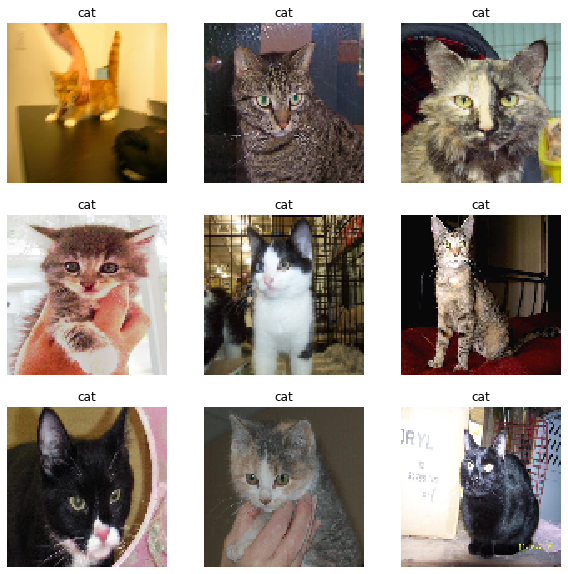

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(y[i])
    plt.axis("off")

In [7]:
# shuffling 
permutation = np.random.permutation(len(images)) 
images = images[permutation]
y = y[permutation]

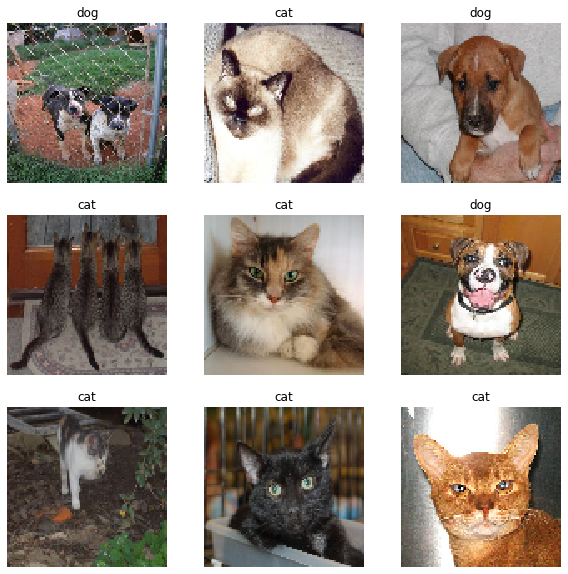

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(y[i])
    plt.axis("off")

In [9]:
y[y == "dog"] = 1 
y[y == "cat"] = 0 
y = y.astype(int)


## Let's start building the network

In [10]:
def residual_block(X_inputs, filters, stride, has_conv=False): 
    
    X_shortcut = X_inputs 
    x = Conv2D(filters[0], 1, padding="valid", strides=stride)(X_inputs) 
    x = BatchNormalization()(x) 
    x = Activation("relu")(x) 

    x = Conv2D(filters[0], 3, padding="same")(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters[1], 1, padding="valid")(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    if has_conv: 
        # convolution on the shortcut 
        X_shortcut = Conv2D(filters[1], 1, padding="valid", strides=stride)(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    
    # add 
    x_out = Add()([x, X_shortcut])
    
    x_out = Activation("relu")(x_out)
    
    return x_out

In [11]:
# x = tf.keras.Input(shape=(28,28, 512))
# residual_block(x, [256, 1024],reduce=True)

In [12]:
def resent50(input_shape, classes): 
    
    # data augmentation thing 
        
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)(x)
    
    x = Conv2D(64, 7, padding="valid", strides=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    
    x = MaxPooling2D(3, strides=2, padding="valid")(x) 
    
    x = residual_block(x, [64, 256], 1, has_conv=True) 
    x = residual_block(x, [64, 256], 1, has_conv=False)
    x = residual_block(x, [64, 256], 1, has_conv=False)
    
    # reduce 
    
    x = residual_block(x, [128, 512], 2, has_conv=True)
    x = residual_block(x, [128, 512], 1, has_conv=False)
    x = residual_block(x, [128, 512], 1, has_conv=False)
    
    # reduce 
    x = residual_block(x, [256, 1024], 2, has_conv=True)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
#     x = residual_block(x, [256, 1024], 1, has_conv=False)
    
    # reduce
    x = residual_block(x, [512, 2048], 2, has_conv=True)
    x = residual_block(x, [512, 2048], 1, has_conv=False)
    
    # dense 
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    if classes == 2: 
        unit = 1 
        activation = "sigmoid"
    else: 
        unit = classes 
        activation = "softmax"
    
    x = tf.keras.layers.Dropout(0.5)(x)

    x = Dense(unit, activation=activation)(x)
    
    
    model = Model(inputs, x)
    
    return model

    

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, shuffle=True)

In [14]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [15]:
def scheduler(epoch, lr): 
    if lr == 5: 
        lr / 10
    if lr == 15: 
        return lr / 10
    if lr > 22: 
        return lr * tf.math.exp(-0.1 * epoch)

    return lr

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
for lr in [0.1, 0.0005, 0.00001]: 
        
    model = resent50((96, 96, 3), 2)
    model.compile(
        tf.keras.optimizers.SGD(lr), 
        "binary_crossentropy", 
        ["accuracy"]
    )
    log_dir = f"logs/fit/simplfifiedv2_bs64_resnet50_lr_{str(lr).replace('.', ',')}" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(
        X_train, y_train, epochs=100, batch_size=64, callbacks=[tensorboard_callback, lr_schedule], validation_data=(X_test, y_test),
    )


Epoch 1/100
250/250 [==============================] - 73s 212ms/step - loss: 3.7068 - accuracy: 0.5157 - val_loss: 0.7469 - val_accuracy: 0.5109
Epoch 2/100
250/250 [==============================] - 45s 179ms/step - loss: 1.1917 - accuracy: 0.5569 - val_loss: 0.7542 - val_accuracy: 0.5959
Epoch 3/100
250/250 [==============================] - 45s 180ms/step - loss: 1.0937 - accuracy: 0.5993 - val_loss: 1.2554 - val_accuracy: 0.5305
Epoch 4/100
250/250 [==============================] - 45s 180ms/step - loss: 1.0019 - accuracy: 0.5840 - val_loss: 42.3184 - val_accuracy: 0.5254
Epoch 5/100
250/250 [==============================] - 45s 180ms/step - loss: 1.0304 - accuracy: 0.6080 - val_loss: 2.0662 - val_accuracy: 0.5069
Epoch 6/100
250/250 [==============================] - 45s 180ms/step - loss: 0.9374 - accuracy: 0.6328 - val_loss: 0.7564 - val_accuracy: 0.5989
Epoch 7/100
250/250 [==============================] - 45s 182ms/step - loss: 0.8340 - accuracy: 0.6676 - val_loss: 1.0059 

Epoch 57/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0273 - accuracy: 0.9923 - val_loss: 1.1272 - val_accuracy: 0.7974
Epoch 58/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 1.1426 - val_accuracy: 0.8072
Epoch 59/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 1.2516 - val_accuracy: 0.8012
Epoch 60/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 1.3590 - val_accuracy: 0.8007
Epoch 61/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 1.2293 - val_accuracy: 0.8170
Epoch 62/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 1.3014 - val_accuracy: 0.8007
Epoch 63/100
250/250 [==============================] - 45s 180ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 2

250/250 [==============================] - 45s 181ms/step - loss: 0.7539 - accuracy: 0.5943 - val_loss: 0.7301 - val_accuracy: 0.5791
Epoch 13/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7555 - accuracy: 0.5923 - val_loss: 0.6970 - val_accuracy: 0.5874
Epoch 14/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7541 - accuracy: 0.5886 - val_loss: 0.6879 - val_accuracy: 0.6039
Epoch 15/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7361 - accuracy: 0.6082 - val_loss: 0.6571 - val_accuracy: 0.6270
Epoch 16/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7177 - accuracy: 0.6132 - val_loss: 0.6210 - val_accuracy: 0.6633
Epoch 17/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7053 - accuracy: 0.6208 - val_loss: 0.6830 - val_accuracy: 0.6149
Epoch 18/100
250/250 [==============================] - 45s 181ms/step - loss: 0.7133 - accuracy: 0.6154 - val_loss: 0.6298 - val_a

Epoch 68/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2782 - accuracy: 0.8841 - val_loss: 0.6389 - val_accuracy: 0.7222
Epoch 69/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2704 - accuracy: 0.8866 - val_loss: 0.6337 - val_accuracy: 0.7192
Epoch 70/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2489 - accuracy: 0.8988 - val_loss: 0.7291 - val_accuracy: 0.7017
Epoch 71/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2438 - accuracy: 0.9023 - val_loss: 0.7467 - val_accuracy: 0.7100
Epoch 72/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2230 - accuracy: 0.9096 - val_loss: 0.7415 - val_accuracy: 0.7120
Epoch 73/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2070 - accuracy: 0.9185 - val_loss: 0.7463 - val_accuracy: 0.7152
Epoch 74/100
250/250 [==============================] - 46s 182ms/step - loss: 0.2057 - accuracy: 0.9182 - val_loss: 1

Epoch 24/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8998 - accuracy: 0.5218 - val_loss: 0.6869 - val_accuracy: 0.5726
Epoch 25/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8898 - accuracy: 0.5291 - val_loss: 0.6860 - val_accuracy: 0.5716
Epoch 26/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8969 - accuracy: 0.5327 - val_loss: 0.6851 - val_accuracy: 0.5736
Epoch 27/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8961 - accuracy: 0.5285 - val_loss: 0.6833 - val_accuracy: 0.5746
Epoch 28/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8850 - accuracy: 0.5390 - val_loss: 0.6855 - val_accuracy: 0.5798
Epoch 29/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8902 - accuracy: 0.5342 - val_loss: 0.6837 - val_accuracy: 0.5721
Epoch 30/100
250/250 [==============================] - 46s 182ms/step - loss: 0.9059 - accuracy: 0.5258 - val_loss: 0

Epoch 80/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8596 - accuracy: 0.5510 - val_loss: 0.6689 - val_accuracy: 0.6027
Epoch 81/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8643 - accuracy: 0.5483 - val_loss: 0.6669 - val_accuracy: 0.6034
Epoch 82/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8634 - accuracy: 0.5457 - val_loss: 0.6659 - val_accuracy: 0.6039
Epoch 83/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8494 - accuracy: 0.5479 - val_loss: 0.6665 - val_accuracy: 0.6069
Epoch 84/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8563 - accuracy: 0.5496 - val_loss: 0.6653 - val_accuracy: 0.6124
Epoch 85/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8583 - accuracy: 0.5532 - val_loss: 0.6637 - val_accuracy: 0.6032
Epoch 86/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8536 - accuracy: 0.5571 - val_loss: 0

In [18]:
model.compile(
    tf.keras.optimizers.SGD(0.0001), 
    "binary_crossentropy", 
    ["accuracy"]
)
log_dir = "logs/fit/resnet50_with_lr_scheduling_v3" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    X_train, y_train, epochs=100, batch_size=64, callbacks=[lr_schedule, tensorboard_callback], validation_data=(X_test, y_test),
)


Epoch 1/100
250/250 [==============================] - 56s 212ms/step - loss: 0.8638 - accuracy: 0.5434 - val_loss: 0.6938 - val_accuracy: 0.5718
Epoch 2/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8586 - accuracy: 0.5425 - val_loss: 0.6961 - val_accuracy: 0.5683
Epoch 3/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8847 - accuracy: 0.5325 - val_loss: 0.6733 - val_accuracy: 0.5974
Epoch 4/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8711 - accuracy: 0.5394 - val_loss: 0.6624 - val_accuracy: 0.6162
Epoch 5/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8617 - accuracy: 0.5464 - val_loss: 0.6695 - val_accuracy: 0.5999
Epoch 6/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8578 - accuracy: 0.5415 - val_loss: 0.6725 - val_accuracy: 0.5924
Epoch 7/100
250/250 [==============================] - 46s 182ms/step - loss: 0.8547 - accuracy: 0.5420 - val_loss: 0.6737 -

Epoch 57/100
250/250 [==============================] - 46s 182ms/step - loss: 0.7280 - accuracy: 0.6048 - val_loss: 0.6342 - val_accuracy: 0.6508
Epoch 58/100
250/250 [==============================] - 45s 182ms/step - loss: 0.7297 - accuracy: 0.5991 - val_loss: 0.6283 - val_accuracy: 0.6445
Epoch 59/100
250/250 [==============================] - 46s 182ms/step - loss: 0.7253 - accuracy: 0.6054 - val_loss: 0.6335 - val_accuracy: 0.6380
Epoch 60/100
250/250 [==============================] - 46s 182ms/step - loss: 0.7169 - accuracy: 0.6013 - val_loss: 0.6348 - val_accuracy: 0.6415
Epoch 61/100
250/250 [==============================] - 46s 182ms/step - loss: 0.7031 - accuracy: 0.6209 - val_loss: 0.6319 - val_accuracy: 0.6448
Epoch 62/100
250/250 [==============================] - 46s 182ms/step - loss: 0.7247 - accuracy: 0.6092 - val_loss: 0.6383 - val_accuracy: 0.6335
Epoch 63/100
250/250 [==============================] - 45s 182ms/step - loss: 0.7171 - accuracy: 0.6081 - val_loss: 0